In [ ]:
!pip install clustergram
!pip install urbangrammar_graphics

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns

In [4]:
df = pd.read_excel("/content/contracts_plus_loses_dash_anomaly.xlsx")
df.head()

,contract_id,contract_num,product_name,client_id,contract_status,currency_name,duration,country,price,insurance_amount,last_name,first_name,middle_name,age,sex,loss_id,loss_name,loss_payout_amt_USD,anomaly
0,21111219,ТТЕ7227715*****,Страхование путешественников,10161870404,Действует,USD,10,Беларусь,1096,2000000,А*****,Х*****,А*****,20,M,NaN,NaN,NaN,0
1,21111381,ТТЕ7227715*****,Страхование путешественников,1017159879,Действует,USD,7,Индонезия,1918,5000000,З*****,Х*****,М*****,55,M,NaN,NaN,NaN,0
2,21112353,БАДАМСТЕ55*****,Страхование путешественников,10161883357,Действует,USD,10,Беларусь,1096,2000000,Б*****,В*****,Щ*****,61,F,NaN,NaN,NaN,0
3,21113224,ТТЕ7227715*****,Страхование путешественников,100766461,Действует,USD,14,Грузия,1534,2000000,И*****,У*****,Н*****,25,M,NaN,NaN,NaN,0
4,21113292,ТТЕ7227715*****,Страхование путешественников,10171604758,Действует,USD,7,Аргентина,1918,5000000,З*****,Ч*****,Г*****,33,M,NaN,NaN,NaN,1


In [5]:
df.drop(['contract_num', 'last_name', 'first_name', 'middle_name', 'loss_id'],  axis=1, inplace = True)

In [6]:
# перекодируем все признаки - в числовые

df_onehot = df.copy()
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['product_name']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('product_name', axis = 1, inplace = True)

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['contract_status']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('contract_status', axis = 1, inplace = True)

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['currency_name']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('currency_name', axis = 1, inplace = True)

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['country']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('country', axis = 1, inplace = True)

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['sex']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('sex', axis = 1, inplace = True)

onehotencoder = OneHotEncoder(sparse = False)
encoded_df = pd.DataFrame(onehotencoder.fit_transform(df_onehot[['loss_name']]))
encoded_df.columns = onehotencoder.get_feature_names_out()
df_onehot = df_onehot.join(encoded_df)
df_onehot.drop('loss_name', axis = 1, inplace = True)

df_onehot = df_onehot.fillna(0)

df_onehot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,contract_id,client_id,duration,price,insurance_amount,age,loss_payout_amt_USD,anomaly,product_name_Страхование путешественников,product_name_Страхование путешественников USD,...,country_США,country_Сирия,country_Таиланд,country_Турция,country_Узбекистан,country_Франция,sex_F,sex_M,loss_name_Оказание медицинской помощи,loss_name_nan
0,21111219,10161870404,10,1096,2000000,20,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,21111381,1017159879,7,1918,5000000,55,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,21112353,10161883357,10,1096,2000000,61,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,21113224,100766461,14,1534,2000000,25,0.0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,21113292,10171604758,7,1918,5000000,33,0.0,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,31133782315,100649013,15,2466,3000000,22,0.0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3707,31133836775,1017151314,7,1918,5000000,33,0.0,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3708,31133933241,1006491844,15,2466,3000000,43,0.0,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3709,3114463583,1006513037,30,4932,3000000,29,0.0,1,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [7]:
scaler = StandardScaler()
df_onehot_ss = scaler.fit_transform(df_onehot)

In [9]:
# провели нормализацию данных
df_onehot_ss

array([[-0.3198631 ,  0.93292691, -0.23503772, ...,  0.78548932,
        -0.11079241,  0.11079241],
       [-0.31986305, -0.98779927, -0.28497331, ...,  0.78548932,
        -0.11079241,  0.11079241],
       [-0.31986269,  0.93292963, -0.23503772, ..., -1.27309179,
        -0.11079241,  0.11079241],
       ...,
       [11.08868735, -0.99003995, -0.15181174, ...,  0.78548932,
        -0.11079241,  0.11079241],
       [ 0.81441737, -0.9900355 ,  0.09786623, ...,  0.78548932,
        -0.11079241,  0.11079241],
       [ 0.81441751,  0.93495781, -0.28497331, ...,  0.78548932,
        -0.11079241,  0.11079241]])

In [10]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_onehot_ss)

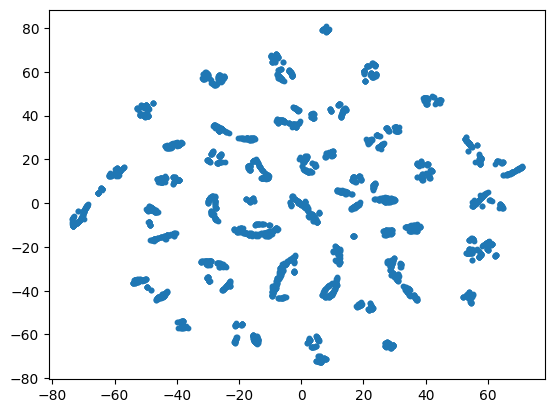

In [11]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10)

In [12]:
clustering = AgglomerativeClustering().fit(df_onehot_ss)
np.unique(clustering.labels_)

array([0, 1])

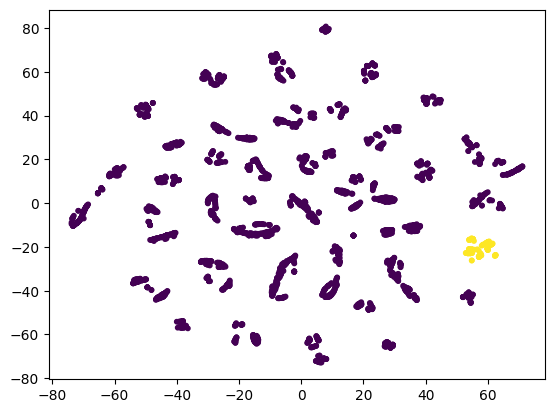

In [13]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

In [14]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df_onehot_ss)

In [15]:
np.unique(clustering.labels_)

array([   0,    1,    2, ..., 3708, 3709, 3710])

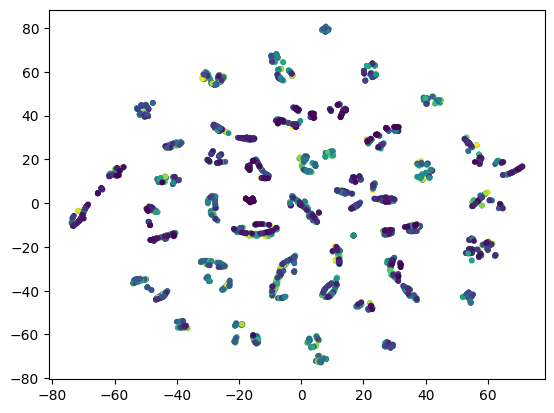

In [16]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

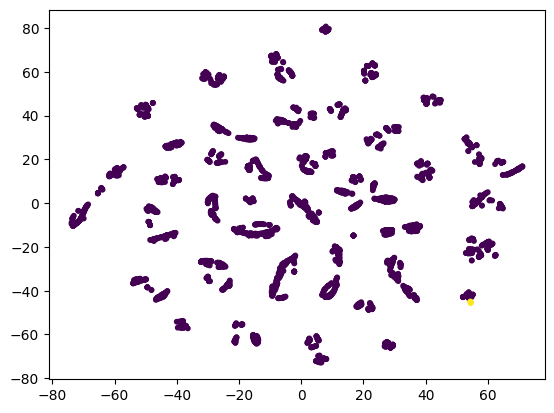

In [17]:
clustering = AgglomerativeClustering(linkage='average').fit(df_onehot_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

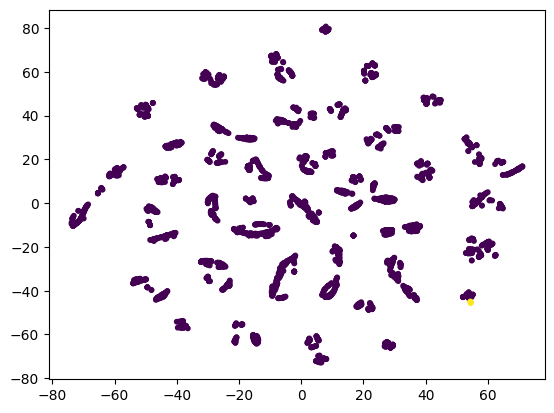

In [18]:
clustering = AgglomerativeClustering(linkage='complete').fit(df_onehot_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

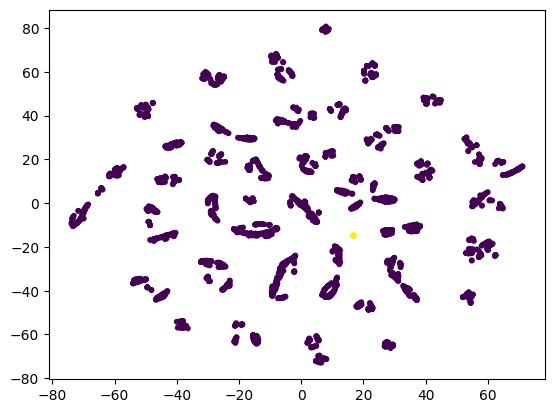

In [19]:
clustering = AgglomerativeClustering(linkage='single').fit(df_onehot_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

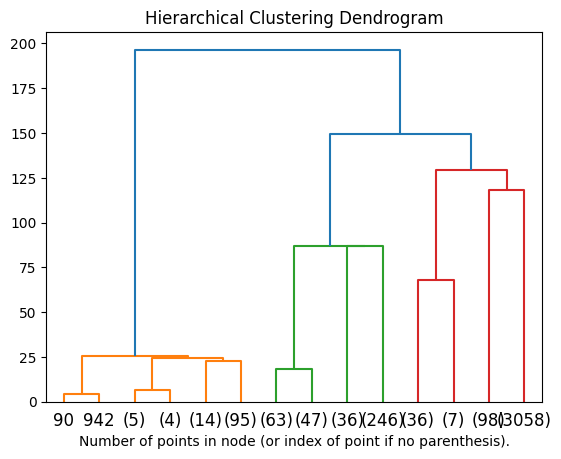

In [20]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_onehot_ss)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [21]:
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_onehot_ss)
    preds = kmeans.predict(df_onehot_ss)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_onehot_ss, preds))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

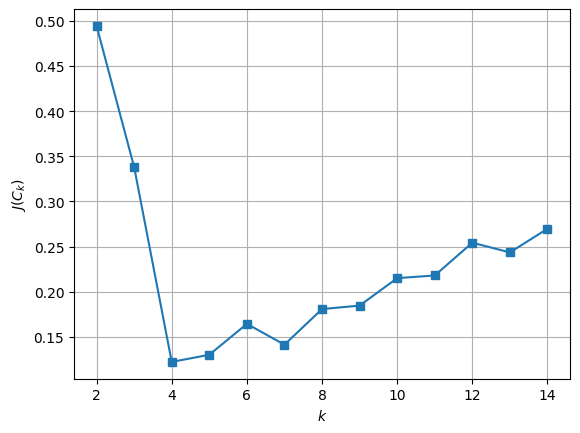

In [22]:
# ищем перегиб для выбора количества кластеров
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


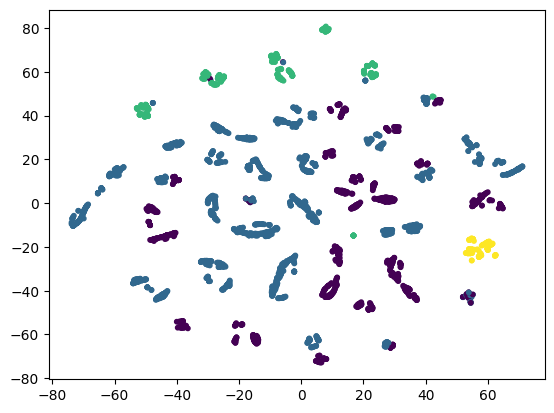

In [23]:
# т.к. точка сгиба на 4 то выбираем 4 кластера для метода К-сердних
kmeans = KMeans(n_clusters=4).fit(df_onehot_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kmeans.labels_)

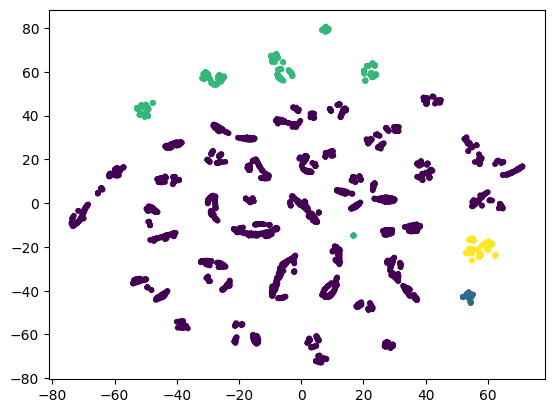

In [24]:
# т.к. точка сгиба на 4 то выбираем 4 кластера для агломеративного метода
clustering = AgglomerativeClustering(n_clusters=4).fit(df_onehot_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

In [25]:
df.head()

,contract_id,product_name,client_id,contract_status,currency_name,duration,country,price,insurance_amount,age,sex,loss_name,loss_payout_amt_USD,anomaly
0,21111219,Страхование путешественников,10161870404,Действует,USD,10,Беларусь,1096,2000000,20,M,NaN,NaN,0
1,21111381,Страхование путешественников,1017159879,Действует,USD,7,Индонезия,1918,5000000,55,M,NaN,NaN,0
2,21112353,Страхование путешественников,10161883357,Действует,USD,10,Беларусь,1096,2000000,61,F,NaN,NaN,0
3,21113224,Страхование путешественников,100766461,Действует,USD,14,Грузия,1534,2000000,25,M,NaN,NaN,0
4,21113292,Страхование путешественников,10171604758,Действует,USD,7,Аргентина,1918,5000000,33,M,NaN,NaN,1


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


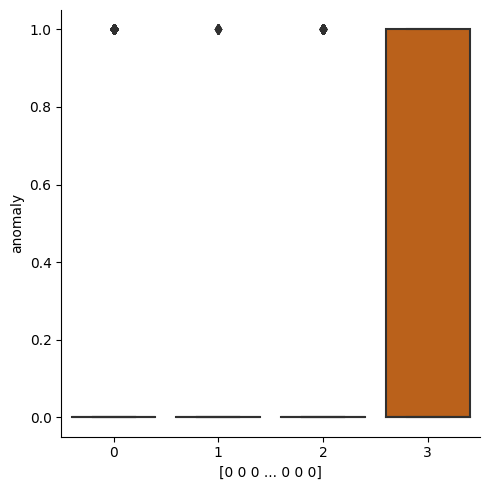

In [32]:
# аномалии присущи 4-му кластеру
sns.catplot(kind='box', data=df,
            y='anomaly',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


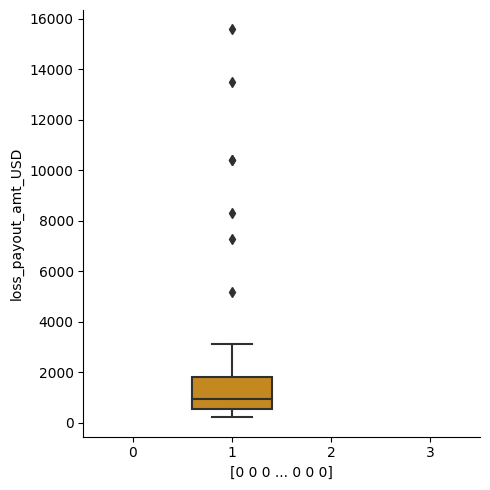

In [27]:
# потери во втором кластере
sns.catplot(kind='box', data=df,
            y='loss_payout_amt_USD',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


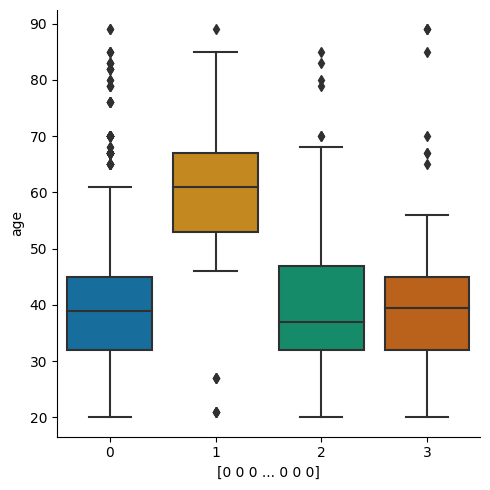

In [29]:
# возраст существенно выше во втором кластере
sns.catplot(kind='box', data=df,
            y='age',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


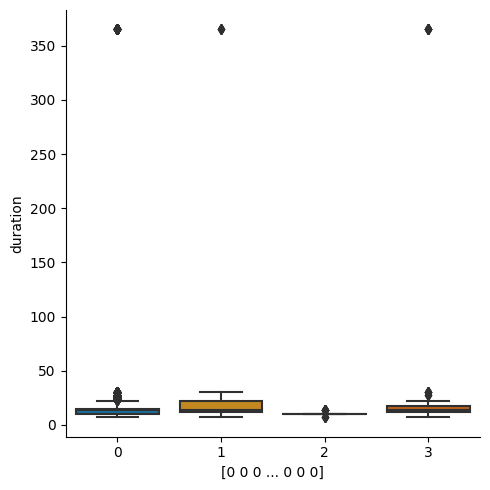

In [30]:
# при этом сроки страхования высокие во втором и четвертом кластере
sns.catplot(kind='box', data=df,
            y='duration',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3203: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


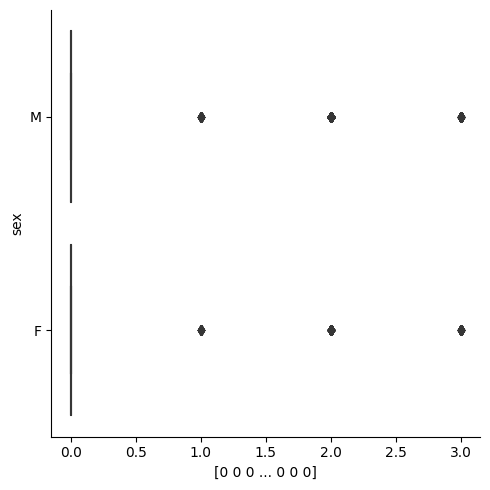

In [33]:
# самое большое отличие кластеров - в первом
sns.catplot(kind='box', data=df,
            y='sex',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


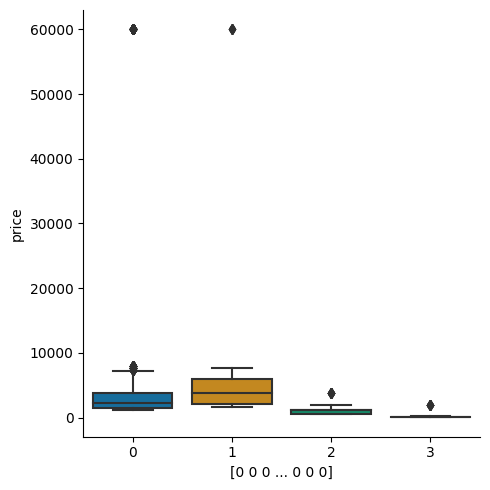

In [31]:
# самое большое отличие кластеров - в первом
sns.catplot(kind='box', data=df,
            y='price',
            x=clustering.labels_,
            palette="colorblind", sharey=False)
plt.tight_layout()
plt.show()

Выводы: Данные разделяются на 4 кластера,
при этом в каждом из кластеров есть свои особенности, во всех кластерах примерно одинаковое разбиение по полу (М/Ж)

1. В первом кластере возрастная группа 40 лет, ценник страховок средний, как и сроки страхования
2. Во втором кластере возрастная группа более старшего возраста, средний возраст 60 лет, сумма страховок выше, как и длительность страховок, при этом высокий риск выплат по страховке.
3. В третьем кластере ниже среднего цена страховок, самая низкая длителдьность страховки, возраст 35-40 лет
4. В четвертом кластере - собраны аномальные клиенты, низкая цена страховок - нестандартные и сомнительные контракты.